<h2>Set everything up</h2>

In [1]:
from astropy.io import fits
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
from mpl_toolkits.mplot3d import Axes3D
import scipy
import scipy.stats as ss
from scipy.optimize import curve_fit
import random
import glob
import pickle

In [3]:
location = '../PFS_CR_cutouts/*/*.fits'

list_of_filenames = sorted( glob.glob( location ) )

print (len(list_of_filenames))

406


Helper functions

In [4]:
def weightCovar(x,y,w):
    '''Returns weighted covariance of two variables'''
    return np.sum(w * (x - np.average(x, weights=w)) * (y - np.average(y, weights=w))) / np.sum(w)

def weightCorr(x,y,w):
    '''Returns weighted Pearson R correlation coefficient'''
    return weightCovar(x, y, w) / np.sqrt(weightCovar(x, x, w) * weightCovar(y, y, w))

def getIntersects(m,b,left,right,top,bot):
    '''
    Return where a line intersects a box
    '''
    yleft = m*left+b
    yright = m*right+b
    int0 = [left,yleft]
    int1 = [right,yright]
    topInt = [(top-b)/m,top]
    botInt = [(bot-b)/m,bot]
    
    if yleft<bot: int0 = botInt
    elif yleft>top: int0 = topInt
    if yright<bot: int1 = botInt
    elif yright>top: int1 = topInt
        
    return int0, int1

def dist2line(m,b,x0,y0):
    '''Distance from a point to a line'''
    return (m*x0 + b - y0) / np.sqrt(m**2 + 1)

def normal(x, mu, sigma, amp):
    '''Function describing normal distribution'''
    return amp * np.exp(-0.5*((x-mu)/sigma)**2)

def weightMeanErr(vals, errs):
    '''Return mean and stdv of sample with measurement uncertainties'''
    variance = 1 / np.sum(1/errs**2)
    mean = np.sum(vals/errs**2) * variance
    stdv = np.sqrt(variance)
    return mean, stdv

In [5]:
class cosmicTrack:
    '''
    Class which stores all info about a track from a fits image and has methods to calculate them
    '''
    
    def __init__(self, file, pitch=15, thickness=100, filetype='fits'):
        # Save fits file to array
        self.filename = file
        if filetype=='fits':
            with fits.open(file) as f:
                self.imArray = f[1].data
        elif filetype=='dat':
            lines = np.loadtxt(file, skiprows=1)
            self.imArray = np.reshape(lines[:,2], (7,7))
        self.yInds, self.xInds = np.where(self.imArray<np.inf)
        self.imWidth = max(self.xInds)
        self.imHeight = max(self.yInds)
        
        # Sensor properties
        self.pitch = pitch # um
        self.thickness = thickness # um
            
        # Get track weighted linear correlation coefficient
        self.linRsq = weightCorr(self.xInds, self.yInds, self.imArray.flatten())**2
        self.isLinear = None
        
        ### Initializing variables -- not strictly necessary in Python, but just to keep track
        # Variables we might plot later
        self.trackLengthPx = None
        self.trackLengthMicron = None
        self.trackAvgDist = None
        self.totSignal = None
        self.signalMeV = None
        self.nBrightPix = None
        self.brightPixPerLength = None
        self.countsPerPix = None
        self.dedx = None
        self.isFat = None
        self.wormed = False
        self.PSFUseable = False
        self.opposingBroads = False
        
        # Other instance variables
        self.thresh = None
        self.brightX = None
        self.brightY = None
        self.maskedX = None
        self.maskedY = None
        self.maskedImArray = self.imArray.copy()
        self.lineM = None
        self.lineB = None
        self.lineEnd0 = None
        self.lineEnd1 = None
        self.nSegments = None
        self.segPixX = []
        self.segPixY = []
        self.segDivX = []
        self.segDivY = []
        self.segDivM = None
        self.segDivB = []
        self.segDists = []
        self.segSignals = []
        self.segGaussian = []
        self.segGaussianErr = []
        self.segDedx = []
        self.segBeta = []
        self.avgSegWidth = None
        self.segDepths = []
        
    def checkIsLinear(self, minRsq):
        self.isLinear = self.linRsq >= minRsq
        return self.isLinear
    
    def setThresh(self, thresh):
        '''
        Set the brightness threshold at which pixels are considered part of the track,
        find total signal of the track
        '''
        self.thresh = thresh
        self.brightY, self.brightX = np.where(self.imArray > thresh)
        self.nBrightPix = len(self.brightY)
        self.totSignal = sum(self.imArray[self.brightY,self.brightX])
    
    def maskPixels(self, maskSigma):
        '''
        Do not include in calculations pixels which are either too far from the track
        or too bright relative to the track (possible deltas)
        '''
        # Fit estimate line, unweighted
        m,b = np.polyfit(self.brightX, self.brightY, deg=1)
        
        # Mask pixels which are farther than maskSigma from this line
        dists = dist2line(m, b, self.brightX, self.brightY)
        tooFar = np.abs(dists)>maskSigma*np.std(dists)
        # Mask pixels which are brighter than 5sigma from the rest of the track
        brightnesses = self.imArray[self.brightY, self.brightX]
        tooBright = brightnesses>5*np.std(brightnesses)
        self.maskedX = self.brightX[tooFar + tooBright]
        self.maskedY = self.brightY[tooFar + tooBright]
        self.maskedImArray[self.maskedY,self.maskedX] = 0
        self.totSignal = sum(self.maskedImArray[self.brightY,self.brightX])
    
    def fitLine(self):
        '''
        Fit a line to the track so we can identify statistics along that line
        '''
        # Fit precise line, weighted by pixel values and excluding
        #masked pixels
        m, b = np.polyfit(self.xInds, self.yInds, deg=1, w=self.maskedImArray.flatten())
#         yindMasked, xindMasked = np.where(self.maskedImArray>self.thresh)
#         m, b = np.polyfit(xindMasked, yindMasked, deg=1)
        self.lineM = m
        self.lineB = b
        
        y = lambda a: m*a+b
        x = lambda a: (a-b)/m
        
        # Find where line intercepts image border
        #(add 0.5 because ints represent center of pixel)
        bound0, bound1 = getIntersects(m,b,-0.5,self.imWidth+0.5,self.imHeight+0.5,-0.5)

        # Find terminal pixels
        pix0 = np.round(bound0).astype(int)
        pix1 = np.round(bound1).astype(int)
        # In case rounding errors return a pixel outside the image
        pix = [pix0,pix1]
        for i in range(2):
            if pix[i][0]<0: pix[i][0] = 0
            elif pix[i][0]>self.imWidth: pix[i][0] = self.imWidth
            if pix[i][1]<0: pix[i][1] = 0
            elif pix[i][1]>self.imHeight: pix[i][1] = self.imHeight
                
        # Find where line enters terminal pixels
        _,inner0 = getIntersects(m,b,pix0[0]-0.5,pix0[0]+0.5,pix0[1]+0.5,pix0[1]-0.5)
        inner1,_ = getIntersects(m,b,pix1[0]-0.5,pix1[0]+0.5,pix1[1]+0.5,pix1[1]-0.5)

        #Length of line excluding terminal pixels
        innerLen = np.linalg.norm(np.subtract(inner1,inner0))

        # Find energy deposited in track excluding terminal pixels (ADU)
        pix0E = self.imArray[pix0[1],pix0[0]]
        pix1E = self.imArray[pix1[1],pix1[0]]
        totE = sum(self.imArray[self.imArray>self.thresh])
        # Avg dE/dx excluding terminal pixels (ADU/px)
        dEdx = (totE-pix0E-pix1E)/innerLen

        # Get track length in terminal pixels based on energy deposition
        pix0len = pix0E/dEdx
        pix1len = pix1E/dEdx

        # Find line endpoints
        xadd0 = pix0len/(1+m**2)**0.5
        self.lineEnd0 = np.array(inner0) - np.array([xadd0,m*xadd0])
        xadd1 = pix1len/(1+m**2)**0.5
        self.lineEnd1 = np.array(inner1) + np.array([xadd1,m*xadd1])
        
        self.trackLengthPx = np.linalg.norm(np.subtract(self.lineEnd1,self.lineEnd0))
        self.trackLengthMicron = np.sqrt((self.trackLengthPx*self.pitch)**2 + self.thickness**2)
        
    def calcAvgDist(self):
        '''
        No longer used
        '''
        # TODO: decide whether to include masked pixels
        # Also, is there a better statistic for this?
        dists = np.abs(dist2line(self.lineM, self.lineB, self.brightX, self.brightY))
        self.trackAvgDist = np.mean(dists)
        
    def calcOthers(self):
        '''
        Various statistics over the length of the track
        '''
        self.brightPixPerLength = self.nBrightPix/self.trackLengthPx
        self.countsPerPix = self.totSignal/self.nBrightPix
#         self.dedx = 0.8 * self.totSignal/self.trackLengthMicron # electrons/micron, 0.8 is fudge factor to account for deltas
        self.dedx = self.totSignal/self.trackLengthMicron # deltas should be removed now, so no 0.8
        
        self.isFat = (self.dedx>200 and self.isLinear)
        self.signalMeV = self.totSignal*3.6/1e6 # convert total signal to MeV
        
        # calculate beta assuming it's constant: dEdx = 80[e/um] / beta^2
        self.beta = np.sqrt(80/self.dedx)
        self.gamma = 1/np.sqrt(1-self.beta**2)

        # calculate momentum assuming muon or proton mass
        self.momentumM = self.gamma*self.beta*106 # muon mass in MeV
        self.momentumP = self.gamma*self.beta*938 # proton mass in MeV

        # calculate fraction of lost energy 
        self.fractionM = self.signalMeV/self.momentumM
        self.fractionP = self.signalMeV/self.momentumP
        
    def createSegments(self, segLength=10, nSegments=None):
        '''
        Divide track into segments of approximate length segLength. Alternatively,
        specify number of segments to use with nSegments.
        '''
        self.segPixX.clear()
        self.segPixY.clear()
        self.segDivX.clear()
        self.segDivY.clear()
        self.segDivB.clear()
        
        if nSegments is None:
            nSegments = int(self.trackLengthPx/segLength)
        if nSegments==0: nSegments=1
        self.nSegments = nSegments
        # Segment dividers
        if self.lineM==0.: self.segDivM = -1e6
        else: self.segDivM = -1/self.lineM
        # Vector representing the track line in each segment
        segVector = (self.lineEnd1-self.lineEnd0)/nSegments

        x = self.lineEnd0[0]
        y = self.lineEnd0[1]
        self.segDivX.append(x)
        self.segDivY.append(y)
        self.segDivB.append(y-self.segDivM*x)

        for i in range(1,nSegments+1):
            # Get segment divisions
            x = self.lineEnd0[0] + i*segVector[0]
            y = self.lineEnd0[1] + i*segVector[1]
            self.segDivX.append(x)
            self.segDivY.append(y)
            self.segDivB.append(y-self.segDivM*x)
            
            # Get pixels between divisions
            inSegmentInds = np.where(np.logical_and(self.brightX > (self.brightY-self.segDivB[i-1])/self.segDivM,
                                                   self.brightX < (self.brightY-self.segDivB[i])/self.segDivM))
            self.segPixX.append(self.brightX[inSegmentInds])
            self.segPixY.append(self.brightY[inSegmentInds])
                
    def calcSegmentDistrbs(self):
        '''
        Fit Gaussian distributions to each segment's pixels to identify location and width
        '''
        self.segDists.clear()
        self.segSignals.clear()
        self.segGaussian.clear()
        self.segDedx.clear()
        self.segBeta.clear()
        
        for i in range(self.nSegments):
            segDists = dist2line(self.lineM, self.lineB, self.segPixX[i], self.segPixY[i])
            segSignals = self.maskedImArray[self.segPixY[i], self.segPixX[i]]
            # Fisher-Levine seems to fit to the histogram instead of the points...
#             segHistSignals, segHistBounds = np.histogram(segDists, weights=segSignals, bins=10, range=(-2.5,2.5))
#             segHistDists = [(segHistBounds[i]+segHistBounds[i+1])/2 for i in range(10)]
            
            # De-emphasize pixels far above the average
            segMean = np.mean(segSignals)
            segStd = np.std(segSignals)
            w = (segSignals-segMean)/segStd
            w = np.array([np.max((j,0.5)) for j in w])
            # Give masked pixels 0 weight
#             w = [np.inf if s==0 else 1 for s in segSignals]
            try:
                (mu,sig,amp),pcov = curve_fit(normal, segDists, segSignals, p0=[0,1,1000], sigma=w)
                gaussianErr = np.sqrt(np.diag(pcov))
            except:
                (mu,sig,amp) = np.array([np.nan,np.nan,np.nan])
                gaussianErr = np.array([np.inf,np.inf,np.inf])
            self.segDists.append(segDists)
            self.segSignals.append(segSignals)
            dedx = sum(segSignals)/(self.trackLengthMicron/self.nSegments)
#             if dedx<200 or self.isFat: #filter out deltas
            self.segGaussian.append(np.array([mu,np.abs(sig),amp])) #Because I'm not careful, sigma is sometimes negative
            self.segGaussianErr.append(gaussianErr)
            self.segDedx.append(dedx)
            self.segBeta.append(np.sqrt(80/dedx))
#             else:
#                 self.segGaussian.append(np.array([np.nan,np.nan,np.nan]))
#                 self.segDedx.append(np.nan)
            
        self.avgSegWidth = 2*self.pitch*np.mean(np.array(self.segGaussian)[:,1])
        
        # Some worms are straight enough to not get caught in the R^2 filter
        # Chance to filter them out here
        # If track is on avg farther than 2 widths away from line, mark as not linear
        arr = np.array(self.segGaussian)
        RMSdist = np.sqrt(np.nanmean((arr[:,0]/arr[:,1])**2))
        if RMSdist>2:
            self.isLinear = False
            self.isFat = False
            self.wormed = True #get worm'd
            
    def calcSegmentDepths(self):
        '''
        Determine the average drift distance of the CCD electrons in each track segment
        '''
        segHeight = self.thickness/self.nSegments
        depths = np.array([i*segHeight+segHeight/2 for i in range(self.nSegments)])
        _,sig,amp = np.array(self.segGaussian).T
        sig *= self.pitch
        _,sigErr,_ = np.array(self.segGaussianErr).T * self.pitch
        
        # for now, ignore any tracks that have uncertain width at any point
        if np.isnan(sig).any() or np.isinf(sigErr).any():
            return
        
        # or remove those segments
#         remove = np.isnan(sig) + np.isinf(sigErr) + np.isnan(sigErr)
#         depths = list(depths[~remove])
#         sig = sig[~remove]
#         amp = amp[~remove]
#         sigErr = sigErr[~remove]
#         self.segGaussian = list(np.array(self.segGaussian)[~remove])
#         self.segGaussianErr = list(np.array(self.segGaussianErr)[~remove])

        (m,b), cov  = np.polyfit(depths, sig, deg=1, w=1/sigErr, cov=True)
        (mErr,bErr) = np.sqrt(np.diag(cov))
        depths = list(depths)
        
        # Marker that this track can be used for PSF calculations
        # (150000 e- is saturation for HSC)
        self.PSFUseable = np.abs(m)>mErr and not np.any(sigErr>0.5*sig) and not np.any(sigErr<1e-3) \
                and not np.any(amp>150000)
        if m<0:
            depths.reverse()
            
        if self.isFat and np.abs(m)<0.035:
            #diffusion and bf likely acting in opposite directions
#             depths.reverse()
            self.opposingBroads = True
        
        self.PSFSlope = m
        self.PSFSlopeErr = mErr
        self.segDepths = depths
        
        
    # Plotting methods
    def showImage(self, showMaskedPix=False, showLine=False, showSegments=False, hideAxes=False, cmapname='viridis'):
        plt.figure(dpi=100)
        plt.imshow(self.imArray, origin='lower', cmap=cmapname)
        plt.colorbar()
        if showMaskedPix:
            plt.scatter(self.maskedX, self.maskedY, c='r', s=5)
        if showLine:
            plt.plot(*zip(self.lineEnd0,self.lineEnd1), c='g')
        if showSegments and self.nSegments is not None:
            xdiff = 1.5/np.sqrt(1+self.segDivM**2)
            for i in range(self.nSegments+1):
                plt.plot([self.segDivX[i]-xdiff,self.segDivX[i]+xdiff],
                         [self.segDivM*(self.segDivX[i]-xdiff)+self.segDivB[i],
                          self.segDivM*(self.segDivX[i]+xdiff)+self.segDivB[i]], c='y')
        if hideAxes: plt.axis('off')
        plt.show()
        
    def showSegmentPixelDistrbs(self):
        for i in range(self.nSegments):
            plt.figure(dpi=100)
#             plt.hist(self.segDists[i], weights=self.segSignals[i], bins=10, range=(-2.5,2.5))
            plt.scatter(self.segDists[i], self.segSignals[i], c='k', zorder=5, s=5)
            x = np.linspace(min(self.segDists[i]), max(self.segDists[i]))
            mu, sig, amp = self.segGaussian[i]
            _, sigErr, _ = self.segGaussianErr[i]
            pitch = self.pitch
            plt.plot(x, normal(x, mu, sig, amp), c='k', lw=0.8)
            plt.xlabel('Distance from line (px)')
            plt.ylabel('Intensity (e-)')
            plt.title(r'$\mu$ = %.2f, $\sigma$ = %.2f$\pm$%.2f, total signal = %i'%(mu*pitch, sig*pitch, 
                                                                                    sigErr*pitch, sum(self.segSignals[i])))
            plt.show()
            
    def plotPerSegment(self, what='gaussian'):
        segLength = self.trackLengthMicron/self.nSegments
        dist = [i*segLength+segLength/2 for i in range(self.nSegments)]
#         dist = np.array(self.segDepths) * np.sqrt(self.trackLengthMicron**2/self.thickness**2)
        if what=='gaussian':
            mu, sig, amp = np.array(self.segGaussian).T
            muErr, sigErr, _ = np.array(self.segGaussianErr).T
#             flux = [sum(s) for s in self.segSignals]
            dedx = self.segDedx

            fig, (ax0,ax1,ax2) = plt.subplots(ncols=3, figsize=(9,3), dpi=100, sharex=True)
            ax0.plot(dist, mu/sig)
            fracErr = np.abs(mu/sig) * np.sqrt((muErr/mu)**2 + (sigErr/sig)**2)
            ax0.fill_between(dist, mu/sig-fracErr, mu/sig+fracErr, alpha=0.2)
            ax0.set_ylabel(r'Track center / Track width (Gaussian $\mu/\sigma$)')
            
            pitch = self.pitch
            sigum = pitch*sig
            ax1.plot(dist, sigum)
            ax1.fill_between(dist, sigum-pitch*sigErr, sigum+pitch*sigErr, alpha=0.2)
            ax1.set_xlabel(r'Distance along track ($\mu$m)')
            ax1.set_ylabel(r'Width of track Gaussian ($\sigma, \mu$m)')
            
            ax2.plot(dist, dedx)
            ax2.set_ylabel(r'dE/dx per segment (e-/$\mu$m)')
            plt.tight_layout()
            plt.show()
        
        if what=='beta':
            fig, (ax0,ax1) = plt.subplots(ncols=2, figsize=(8,3), dpi=100)
            ax0.plot(dist, self.segBeta)
            ax0.set_xlabel(r'Distance along track ($\mu$m)')
            ax0.set_ylabel(r'$\beta$')
            
            ax1.scatter(self.segDedx, self.segBeta)
            ax1.set_xlabel(r'dE/dx (e-/$\mu$m)')
            ax1.set_ylabel(r'$\beta$')
            plt.tight_layout()
            plt.show()

<h2>Look at some tracks</h2>

In [28]:
#Initialize track objects
tracks = [cosmicTrack(f,pitch=15,thickness=200) for f in list_of_filenames]

#Do calculations
for t in tracks:
    t.checkIsLinear(minRsq = 0.95)
    if t.isLinear:
        t.setThresh(thresh = 30)
        t.maskPixels(maskSigma = 1.5)
        t.fitLine()
        t.calcOthers() #mostly stats Jocelyn found
        t.createSegments(nSegments=8)

C:\Users\tgrosson\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:183: RuntimeWarning: invalid value encountered in sqrt


In [29]:
linears = [t for t in tracks if t.isLinear]
fats = [t for t in linears if t.isFat]
print(len(fats), len(linears), len(tracks))

for i,t in enumerate(linears):
    t.calcSegmentDistrbs()
    try:
        t.calcSegmentDepths()
    except:
        print(i)
        print(np.array(t.segGaussianErr).T[1])
#         t.showImage(True,True,True)
#         t.plotPerSegment()
    
linears = [t for t in tracks if t.isLinear]
fats = [t for t in tracks if t.isFat]
worms = [t for t in tracks if t.wormed]
print(len(fats), len(linears), len(tracks))

21 156 406


C:\Users\tgrosson\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\tgrosson\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:254: RuntimeWarning: invalid value encountered in true_divide
C:\Users\tgrosson\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:271: RuntimeWarning: divide by zero encountered in double_scalars
C:\Program Files\Python37\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Program Files\Python37\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
C:\Program Files\Python37\lib\site-packages\numpy\core\_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
C:\Program Files\Python37\lib\site-packages\numpy\co

21 143 406


or use presaved track lists

In [7]:
with open('../ComCam_linears.obj', 'rb') as file:
    linears = pickle.load(file)
with open('../ComCam_fats.obj', 'rb') as file:
    fats = pickle.load(file)

In [8]:
len([t for t in linears if t.PSFUseable])

2184

In [ ]:
for t in fats:
    sig = np.array(t.segGaussian).T[1] * t.pitch
    sigErr = np.array(t.segGaussianErr).T[1]*t.pitch
    t.showImage(False,True,True)
#     t.showImage(showMaskedPix=True, showLine=True, showSegments=True)
#     print(sigErr/sig<0.5)
#     print(t.PSFUseable)
    t.plotPerSegment()
#     t.showSegmentPixelDistrbs()

In [ ]:
for i,t in enumerate(linears):
    sig = np.array(t.segGaussian).T[1] * t.pitch
    sigErr = np.array(t.segGaussianErr).T[1]*t.pitch
    if  (not t.isFat) and np.any(sig>20):
        t.showImage(showMaskedPix=True, showLine=True, showSegments=True)
        print(sigErr/sig<0.2)
        t.plotPerSegment()
        
#         print(sig)
#         if np.any(sig<4):
#         t.showSegmentPixelDistrbs()
#         vals = t.imArray[t.imArray>30]
#         plt.hist(vals)
#         plt.axvline(3*np.std(vals), color='b')
#         plt.axvline(5*np.std(vals), color='r')
#         if t.nSegments<7: t.showSegmentPixelDistrbs()

<h2>Find PSF as function of depth</h2>

In [9]:
def getPSF(tracks):
    '''
    Function which takes a list of cosmicTrack objects which have been divided into segments
    and the width of the track calculated in each segment, and finds the average width at each
    depth, along with uncertainty.
    '''
    allWidths = {}
    for t in tracks:
        _,sig,_ = np.array(t.segGaussian).T * t.pitch
        _,sigErr,_ = np.array(t.segGaussianErr).T * t.pitch
        dep = t.segDepths
        
        for i,d in enumerate(dep):
            if sigErr[i] < 0.2*sig[i] and not (np.isnan(sig[i]).any() or np.isinf(sigErr[i]).any()):
                s = np.array([[sig[i]],[sigErr[i]]])
                if not d in allWidths:
                    allWidths[d] = s
                else:
                    allWidths[d] = np.hstack((allWidths[d], s))
                
    depths = [d for d in allWidths]
    PSF = []
    PSFErr = []
    for d in depths:
        sig = allWidths[d][0]
        sigErr = allWidths[d][1]

        (meanWidth,meanWidthErr) = weightMeanErr(sig,sigErr)
#         meanWidth = np.median(sig)
#         meanWidthErr = np.median(np.abs(sig-meanWidth))
        PSF.append(meanWidth)
        PSFErr.append(meanWidthErr)
        
    return np.array(depths), np.array(PSF), np.array(PSFErr), allWidths

def PSF_diff_fn(depth, coeff):
    return np.sqrt(coeff*depth)

def get_rchisq(fn, fnPars, x, y, yerr):
    resid = fn(x, *fnPars) - y
    return sum(resid**2/yerr**2) / (len(x)-len(fnPars))

C:\Users\tgrosson\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in sqrt


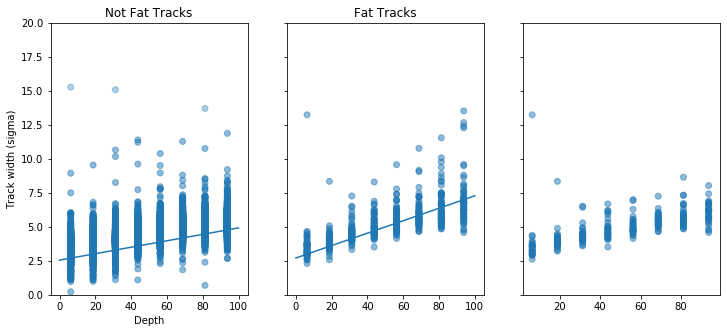

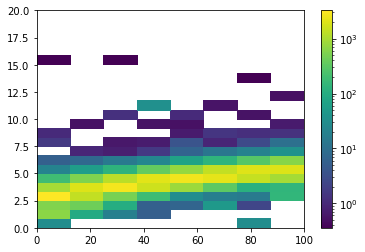

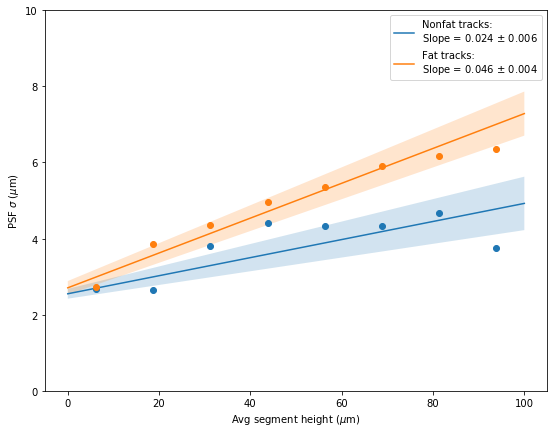

In [10]:
# Get PSF for non-fat and fat tracks
notFatDepths, notFatPSF, notFatPSFErr, notFatWidths = getPSF([t for t in linears if t.PSFUseable and not t.isFat])
fatDepths, fatPSF, fatPSFErr, fatWidths = getPSF([t for t in linears if t.PSFUseable and t.isFat])# and not t.opposingBroads])
fatDepths2, fatPSF2, fatPSFErr2, fatWidths2 = getPSF([t for t in linears if t.PSFUseable and t.isFat and t.opposingBroads])

thick=100
pitch=10

# Plot depths in all tracks, opacity weighted by uncertainty
fig, (ax0,ax1,ax3) = plt.subplots(ncols=3, figsize=(12,5), sharey=True)
alld = np.array([])
allsig = np.array([])
allsigerr = np.array([])
for d in notFatDepths:
    (sig,sigErr) = notFatWidths[d]
    rgba = np.zeros((len(sig),4))
    rgba[:,0] = 31/255
    rgba[:,1] = 119/255
    rgba[:,2] = 180/255
    rgba[:,3] = [np.min([1/e, 0.5]) for e in sigErr]
    ax0.scatter([d]*len(sig), sig, c=rgba)
    alld = np.append(alld, [d]*len(sig))
    allsig = np.append(allsig, sig)
    allsigerr = np.append(allsigerr, sigErr)
for d in fatDepths:
    (sig,sigErr) = fatWidths[d]
    rgba = np.zeros((len(sig),4))
    rgba[:,0] = 31/255
    rgba[:,1] = 119/255
    rgba[:,2] = 180/255
    rgba[:,3] = [np.min([1/e, 0.5]) for e in sigErr]
    ax1.scatter([d]*len(sig), sig, c=rgba)
#     alld = np.append(alld, [d]*len(sig))
#     allsig = np.append(allsig, sig)
#     allsigerr = np.append(allsigerr, sigErr)
for d in fatDepths2:
    (sig,sigErr) = fatWidths2[d]
    rgba = np.zeros((len(sig),4))
    rgba[:,0] = 31/255
    rgba[:,1] = 119/255
    rgba[:,2] = 180/255
    rgba[:,3] = [np.min([1/e, 0.5]) for e in sigErr]
    ax3.scatter([d]*len(sig), sig, c=rgba)

ax0.set_title('Not Fat Tracks')
ax1.set_title('Fat Tracks')
ax0.set_ylabel('Track width (sigma)')
ax0.set_xlabel('Depth')
plt.ylim(0,20)

plt.figure()
plt.hist2d(alld, allsig, bins=(len(notFatDepths),24), range=((0,thick),(0,20)), weights=1/allsigerr, norm=mpl.colors.LogNorm())
plt.colorbar()
ax2 = plt.gca()


# Best fitting lines to the PSFs
(m0,b0), cov0 = np.polyfit(notFatDepths, notFatPSF, deg=1, w=1/np.array(notFatPSFErr), cov=True)
(m1,b1), cov1 = np.polyfit(fatDepths, fatPSF, deg=1, w=1/np.array(fatPSFErr), cov=True)
cov0 = np.sqrt(np.diag(cov0))
cov1 = np.sqrt(np.diag(cov1))
# b0 and b1 should be the intrinsic resolution of the camera, sigma_0
# get the diffusion components, simga_diff
notFatPSF_diff = np.sqrt(notFatPSF**2 - b0**2)
notFatPSF_diffErr = np.sqrt((notFatPSF/notFatPSF_diff*notFatPSFErr)**2 + (b0/notFatPSF_diff*cov0[1])**2)
inds = [not np.isnan(p) for p in notFatPSF_diff]
coeff0,sqrtErr0 = curve_fit(PSF_diff_fn, notFatDepths[inds], notFatPSF_diff[inds], sigma=notFatPSF_diffErr[inds])
sqrtErr0 = np.sqrt(sqrtErr0[0,0])
rchisq0 = get_rchisq(PSF_diff_fn, coeff0, notFatDepths[inds], notFatPSF_diff[inds], notFatPSF_diffErr[inds])

fatPSF_diff = np.sqrt(fatPSF**2 - b1**2)
fatPSF_diffErr = np.sqrt((fatPSF/fatPSF_diff*fatPSFErr)**2 + (b1/fatPSF_diff*cov1[1])**2)
inds = [not np.isnan(p) for p in fatPSF_diff]
coeff1,sqrtErr1 = curve_fit(PSF_diff_fn, fatDepths[inds], fatPSF_diff[inds], sigma=fatPSF_diffErr[inds])
sqrtErr1 = np.sqrt(sqrtErr1[0,0])
rchisq1 = get_rchisq(PSF_diff_fn, coeff1, fatDepths[inds], fatPSF_diff[inds], fatPSF_diffErr[inds])

ax2.errorbar(notFatDepths, notFatPSF, notFatPSFErr, fmt='none')


# Recreate Fig. 3 from Fisher-Levine & Nomerotski 2015
d = np.linspace(0,thick)
ax0.plot(d, m0*d+b0)
ax1.plot(d, m1*d+b1)

plt.figure(figsize=(9,7))
plt.errorbar(notFatDepths, notFatPSF, notFatPSFErr, fmt='o')
lab = 'Nonfat tracks:\n' +\
      r'Slope = %.3f $\pm$ %.3f'%(m0, cov0[0])
plt.plot(d, m0*d+b0, c='C0', label=lab)
ax = plt.gca()
ax.fill_between(d, (m0-cov0[0])*d+b0-cov0[1], (m0+cov0[0])*d+b0+cov0[1], alpha=0.2)
# plt.errorbar(notFatDepths, notFatPSF_diff, notFatPSF_diffErr, fmt='none', c='C2')
# lab = r'Not fat $\sigma_{diff} = \sqrt{%.2f\Delta z}$, $\chi_r^2 = %.3f$'%(coeff0, rchisq0)
# plt.plot(d, PSF_diff_fn(d, coeff0), '--', c='C2', label=lab)
# ax.fill_between(d, PSF_diff_fn(d, coeff0-sqrtErr0), PSF_diff_fn(d, coeff0+sqrtErr0), alpha=0.2, color='C2')

plt.errorbar(fatDepths, fatPSF, fatPSFErr, fmt='o')
lab = 'Fat tracks:\n' +\
      r'Slope = %.3f $\pm$ %.3f'%(m1, cov1[0])
plt.plot([0,thick], [b1,thick*m1+b1], c='C1', label=lab)
ax.fill_between(d, (m1-cov1[0])*d+b1-cov1[1], (m1+cov1[0])*d+b1+cov1[1], alpha=0.2)
# plt.errorbar(fatDepths, fatPSF_diff, fatPSF_diffErr, fmt='none', c='C3')
# lab = r'Fat $\sigma_{diff} = \sqrt{%.2f\Delta z}$, $\chi_r^2 = %.3f$'%(coeff1, rchisq1)
# plt.plot(d, PSF_diff_fn(d, coeff1), '--', c='C3', label=lab)
# ax.fill_between(d, PSF_diff_fn(d, coeff1-sqrtErr1), PSF_diff_fn(d, coeff1+sqrtErr1), alpha=0.2, color='C3')

# plt.plot([0],[pitch/np.sqrt(12)],'ok')

plt.ylim(0,10)
plt.xlabel(r'Avg segment height ($\mu$m)')
plt.ylabel(r'PSF $\sigma$ ($\mu$m)')
# plt.title(r'Expected Intercept: $\sigma_0 = \frac{pitch}{\sqrt{12}} = %.2f$'%(15/np.sqrt(12)))
plt.legend()

In [7]:
print(notFatPSF)
print(10/np.sqrt(12))

[3.74636885 4.67222976 4.33603138 4.34071141 4.40362461 3.79490122
 2.64620248 2.67615286]
2.886751345948129


C:\Users\tgrosson\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in sqrt


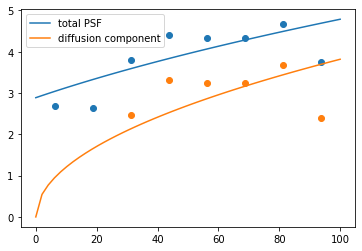

In [11]:
# inds = np.array([False]+9*[True])
# inds = np.array(7*[True]+[False])
# inds = np.array(2*[False]+6*[True])
inds = np.array(6*[True]+2*[False])

plt.scatter(notFatDepths, notFatPSF)
plt.scatter(notFatDepths[inds], np.sqrt(notFatPSF[inds]**2 - 100/12))

def sqrtfn(depth, c):
    return c*np.sqrt(depth)

c_diff, cov_c_diff = curve_fit(sqrtfn, notFatDepths[inds], np.sqrt(notFatPSF[inds]**2 - 100/12))
c_diff = c_diff[0]

dom = np.linspace(0,100)
plt.plot(dom, np.sqrt(100/12 + c_diff**2 *dom), label='total PSF')

sig_diff = np.sqrt((m0*dom+b0)**2 - 100/12)
# plt.plot(dom, sig_diff)
plt.plot(dom, sqrtfn(dom, c_diff), label='diffusion component')

plt.legend()
plt.show()

In [8]:
print(c_diff, '+/-', np.sqrt(cov_c_diff[0,0]))

0.381707712989749 +/- 0.03768888327482333


<h2>See how dE/dx affects width</h2>

First look at simulated images

In [13]:
filededxs = [4,80,400,800,1200,1600]
h = 90
files = [f'../Poisson_CCD/{h}/Pixels_dEdx{dedx}_{h}.dat' for dedx in filededxs]
filededxs = [4,80,400,800,1200,1600]
h = 40
files40 = [f'../Poisson_CCD/{h}/Pixels_dEdx{dedx}_{h}.dat' for dedx in filededxs]

simTracks = [cosmicTrack(f,pitch=10,thickness=100,filetype='dat') for f in files]
for t in simTracks:
    #manually create the line since the class doesn't like horizontal
    t.lineM = 0.
    t.lineB = 3.
    t.lineEnd0 = np.array([-0.5,3.])
    t.lineEnd1 = np.array([6.5,3.])
    t.trackLengthPx = np.linalg.norm(np.subtract(t.lineEnd1,t.lineEnd0))
    t.trackLengthMicron = t.trackLengthPx * t.pitch
    t.isLinear=True
    t.setThresh(-1)
    t.calcOthers()
    
    t.createSegments(nSegments=1)
    t.calcSegmentDistrbs()
    
#     print(t.dedx)
#     t.showImage(True,True,True)
#     t.showSegmentPixelDistrbs()

simTracks40 = [cosmicTrack(f,pitch=10,thickness=100,filetype='dat') for f in files40]
for t in simTracks40:
    #manually create the line since the class doesn't like horizontal
    t.lineM = 0.
    t.lineB = 3.
    t.lineEnd0 = np.array([-0.5,3.])
    t.lineEnd1 = np.array([6.5,3.])
    t.trackLengthPx = np.linalg.norm(np.subtract(t.lineEnd1,t.lineEnd0))
    t.trackLengthMicron = t.trackLengthPx * t.pitch
    t.isLinear=True
    t.setThresh(-1)
    t.calcOthers()
    
    t.createSegments(nSegments=1)
    t.calcSegmentDistrbs()
    
# simTracks[0].showImage(True,True,True)

C:\Users\tgrosson\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:183: RuntimeWarning: invalid value encountered in sqrt
C:\Users\tgrosson\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:183: RuntimeWarning: divide by zero encountered in double_scalars


In [15]:
nodiff = cosmicTrack('../Poisson_CCD/no_diff/Pixels_dEdx400_90.dat',pitch=10,thickness=100,filetype='dat')
nodiff.lineM=0.
nodiff.lineB=3.
nodiff.lineEnd0 = np.array([-0.5,3.])
nodiff.lineEnd1 = np.array([6.5,3.])
nodiff.trackLengthPx = np.linalg.norm(np.subtract(nodiff.lineEnd1,nodiff.lineEnd0))
nodiff.trackLengthMicron = nodiff.trackLengthPx * nodiff.pitch
nodiff.isLinear=True
nodiff.setThresh(-1)
nodiff.calcOthers()

nodiff.createSegments(nSegments=1)
nodiff.calcSegmentDistrbs()

dedx_nd = nodiff.dedx
_,width_nd,_ = np.array(nodiff.segGaussian).T * nodiff.pitch

<IPython.core.display.Javascript object>


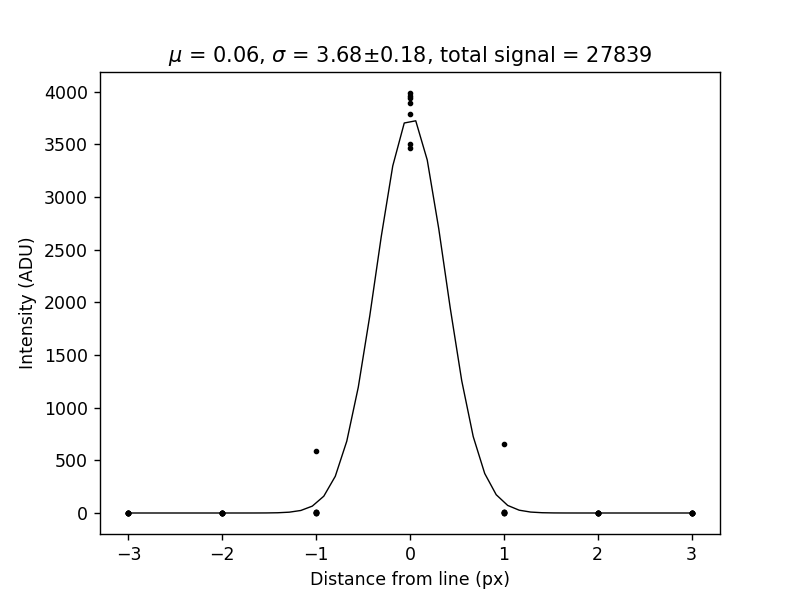

0.24919304004962495


In [60]:
nodiff.showSegmentPixelDistrbs()
print(isolate_sig_rep(6.42, 10, c_diff, 90)-isolate_sig_rep(6.25, 10, c_diff, 90))

In [81]:
def isolate_sig_rep(width, pitch, c_diff, depth):
    sig_rep2 = width**2 - (pitch**2)/12 - c_diff**2 *depth
    sig_rep = np.sqrt(sig_rep2)# * (sig_rep2>0))
    return sig_rep
def sqrtfn2(dedx, a, b):
    return a*np.sqrt(dedx) + b
def linear(x, m, b):
    return m*x+b
def power(x, a, b, c):
    return a * x**b + c
def sqrtfn3(dedx, a, b):
    return np.sqrt(a*dedx + b**2)

C:\Users\tgrosson\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in sqrt
  if sys.path[0] == '':
C:\Users\tgrosson\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in sqrt
  app.launch_new_instance()
C:\Users\tgrosson\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\tgrosson\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in multiply
  if sys.path[0] == '':
C:\Users\tgrosson\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in add
  if sys.path[0] == '':


Text(0.5, 1.0, 'Width of simulated cosmic rays')

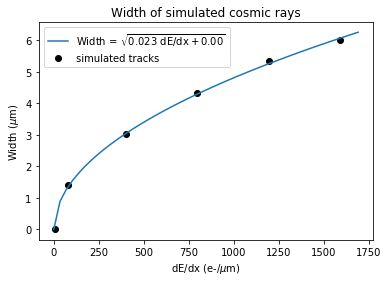

In [103]:
dedxs_sim = np.array([])
widths_sim = np.array([])
for t in simTracks:
    dedxs_sim = np.append(dedxs_sim, t.dedx)
    _,sig,_ = np.array(t.segGaussian).T * t.pitch
#     sig = isolate_sig_rep(sig, 10, c_diff, 90)
    widths_sim = np.append(widths_sim, sig)
    

fn = sqrtfn3

res_sim, cov_sim = curve_fit(fn, dedxs_sim, widths_sim)
cov_sim = np.sqrt(np.diag(cov_sim))

#subtract width(dE/dx=0) and refit
widths_sim = np.sqrt(widths_sim**2 - res_sim[-1]**2)
widths_sim[np.isnan(widths_sim)] = 0
res_sim, cov_sim = curve_fit(fn, dedxs_sim, widths_sim)
cov_sim = np.sqrt(np.diag(cov_sim))


plt.figure()
plt.scatter(dedxs_sim, widths_sim, c='k', label='simulated tracks')
dom_sim = np.linspace(0,max(dedxs_sim)+100)

# plt.plot(dom_sim, fn(dom_sim, *res_sim), label=r'Width = %.3f dE/dx + %.2f'%(res_sim[0],res_sim[1]))
# plt.plot(dom_sim, fn(dom_sim, *res_sim), label=r'Width = %.3f $\sqrt{\rm{dE/dx}}$ + %.2f'%(res_sim[0],res_sim[1]))
# plt.plot(dom_sim, fn(dom_sim, *res_sim), label=r'Width = %.3f (dE/dx)$^{%.3f}$ + %.2f'%(res_sim[0],res_sim[1],res_sim[2]))
plt.plot(dom_sim, fn(dom_sim, *res_sim), label=r'Width = $\sqrt{%.3f~\rm{dE/dx} + %.2f}$'%(res_sim[0],res_sim[1]**2))
plt.fill_between(dom_sim, fn(dom_sim, *(res_sim-cov_sim)), fn(dom_sim, *(res_sim+cov_sim)), alpha=0.2)

plt.xlabel(r'dE/dx (e-/$\mu$m)')
plt.ylabel(r'Width ($\mu$m)')
plt.legend()
plt.title('Width of simulated cosmic rays')

C:\Users\tgrosson\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in sqrt
  if sys.path[0] == '':
C:\Users\tgrosson\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in sqrt
  from ipykernel import kernelapp as app
C:\Users\tgrosson\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\tgrosson\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in multiply
  if sys.path[0] == '':
C:\Users\tgrosson\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in add
  if sys.path[0] == '':
C:\Users\tgrosson\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered 

(0, 8)

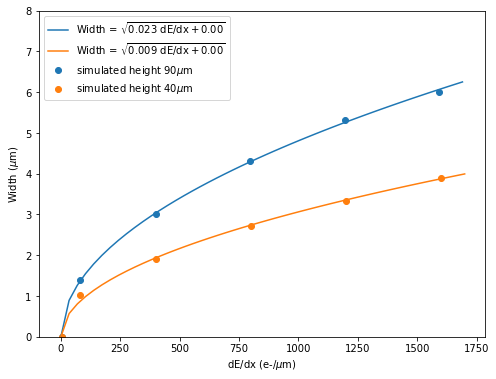

In [73]:
dedxs_sim40 = np.array([])
widths_sim40 = np.array([])
for t in simTracks40:
    dedxs_sim40 = np.append(dedxs_sim40, t.dedx)
    _,sig,_ = np.array(t.segGaussian).T * t.pitch
#     sig = isolate_sig_rep(sig, 10, c_diff, 40)
    if np.isnan(sig): sig=0
    widths_sim40 = np.append(widths_sim40, sig)


res_sim40, cov_sim40 = curve_fit(fn, dedxs_sim40, widths_sim40)
cov_sim40 = np.sqrt(np.diag(cov_sim40))

#subtract width(dE/dx=0) and refit
widths_sim40 = np.sqrt(widths_sim40**2 - res_sim40[-1]**2)
widths_sim40[np.isnan(widths_sim40)] = 0
res_sim40, cov_sim40 = curve_fit(fn, dedxs_sim40, widths_sim40)
cov_sim40 = np.sqrt(np.diag(cov_sim40))



plt.figure(figsize=(8,6))
plt.scatter(dedxs_sim, widths_sim, c='C0', label=r'simulated height 90$\mu$m')
# plt.plot(dom_sim, fn(dom_sim, *res_sim), label=r'Width = %.3f dE/dx + %.2f'%(res_sim[0],res_sim[1]))
# plt.plot(dom_sim, fn(dom_sim, *res_sim), label=r'Width = %.3f $\sqrt{\rm{dE/dx}}$ + %.2f'%(res_sim[0],res_sim[1]))
# plt.plot(dom_sim, fn(dom_sim, *res_sim), label=r'Width = %.3f (dE/dx)$^{%.3f}$ + %.2f'%(res_sim[0],res_sim[1],res_sim[2]))
plt.plot(dom_sim, fn(dom_sim, *res_sim), label=r'Width = $\sqrt{%.3f~\rm{dE/dx} + %.2f}$'%(res_sim[0],res_sim[1]**2))
plt.fill_between(dom_sim, fn(dom_sim, *(res_sim-cov_sim)), fn(dom_sim, *(res_sim+cov_sim)), alpha=0.2)

plt.scatter(dedxs_sim40, widths_sim40, c='C1', label=r'simulated height 40$\mu$m')
dom_sim40 = np.linspace(0,max(dedxs_sim40)+100)
# plt.plot(dom_sim40, fn(dom_sim40, *res_sim40),
#          label=r'Width = %.3f dE/dx + %.2f'%(res_sim40[0],res_sim40[1]))
# plt.plot(dom_sim40, fn(dom_sim40, *res_sim40),
#          label=r'Width = %.3f $\sqrt{\rm{dE/dx}}$ + %.2f'%(res_sim40[0],res_sim40[1]))
# plt.plot(dom_sim40, fn(dom_sim40, *res_sim40),
#          label=r'Width = %.3f (dE/dx)$^{%.3f}$ + %.2f'%(res_sim40[0],res_sim40[1],res_sim40[2]))
plt.plot(dom_sim40, fn(dom_sim40, *res_sim40),
         label=r'Width = $\sqrt{%.3f~\rm{dE/dx} + %.2f}$'%(res_sim40[0],res_sim40[1]**2))
plt.fill_between(dom_sim40, fn(dom_sim40, *(res_sim40-cov_sim40)), fn(dom_sim40, *(res_sim40+cov_sim40)), alpha=0.2)

plt.xlabel(r'dE/dx (e-/$\mu$m)')
plt.ylabel(r'Width ($\mu$m)')
plt.legend()
plt.ylim(0,8)
# plt.title('Width of simulated cosmic rays')

# plt.errorbar(dedxs_sim[2:4], widths_sim[2:4], [0.266,0.249], fmt='none', c='C0')
# plt.errorbar([397.7,794.9], [3.68,5.00], [0.18,0.15], fmt='o', c='k')

And now observed tracks

(-0.05, 1.05, -0.05, 1.05)

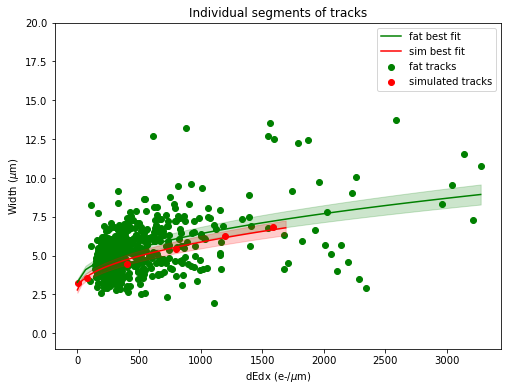

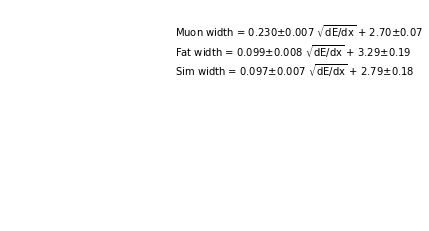

In [18]:
dedxs = np.array([])
widths = np.array([])
widthErrs = np.array([])
depths = np.array([])
lengths = np.array([])
dedxs_fat = np.array([])
widths_fat = np.array([])
widthErrs_fat = np.array([])
depths_fat = np.array([])
lengths_fat = np.array([])
opposing = np.array([], dtype=bool)
for t in linears:
    if t.PSFUseable:
        _, sig, _ = np.array(t.segGaussian).T * t.pitch
        _, sigErr, _ = np.array(t.segGaussianErr).T * t.pitch
        dep = np.array(t.segDepths)
        length = [t.trackLengthMicron]*t.nSegments
#         if t.opposingBroads: dep = np.flip(dep)
#         sig = isolate_sig_rep(sig, 10, c_diff, dep)
        if t.isFat:
            dedxs_fat = np.append(dedxs_fat, t.segDedx)
            widths_fat = np.append(widths_fat, sig)
            widthErrs_fat = np.append(widthErrs_fat, sigErr)
            depths_fat = np.append(depths_fat, dep)
            lengths_fat = np.append(lengths_fat, length)
            opposing = np.append(opposing, [t.opposingBroads]*len(sig))
            continue
        dedxs = np.append(dedxs, t.segDedx)
        widths = np.append(widths, sig)
        widthErrs = np.append(widthErrs, sigErr)
        depths = np.append(depths, dep)
        lengths = np.append(lengths, length)

remove = np.logical_or(np.isnan(widths), widths>40)
dedxs = dedxs[~remove]
widths = widths[~remove]
widthErrs = widthErrs[~remove]
depths = depths[~remove]
lengths = lengths[~remove]

remove_fat = np.logical_or(np.isnan(widths_fat), widths_fat>40)
dedxs_fat = dedxs_fat[~remove_fat]
widths_fat = widths_fat[~remove_fat]
widthErrs_fat = widthErrs_fat[~remove_fat]
depths_fat = depths_fat[~remove_fat]
lengths_fat = lengths_fat[~remove_fat]
opposing = opposing[~remove_fat]

fn = sqrtfn2

res, cov = curve_fit(fn, dedxs, widths)
cov = np.sqrt(np.diag(cov))

res_fat, cov_fat = curve_fit(fn, dedxs_fat, widths_fat)
cov_fat = np.sqrt(np.diag(cov_fat))

res_sim, cov_sim = curve_fit(fn, dedxs_sim, widths_sim)
cov_sim = np.sqrt(np.diag(cov_sim))

# res_all, cov_all = np.polyfit(np.append(dedxs,dedxs_fat), np.append(widths,widths_fat), 
#                                     deg=1, cov=True)#, w=1/np.append(widthErrs,widthErrs_fat))
# cov_all = np.sqrt(np.diag(cov_all))

plt.figure(figsize=(8,6))
# plt.scatter(dedxs, widths, label='muon tracks', c='b')
plt.scatter(dedxs_fat, widths_fat, label='fat tracks', c='g')
plt.ylim(-1,20)

# dom = np.linspace(0,max(dedxs)+200)
# plt.plot(dom, fn(dom, *res), c='b', label='muon best fit')#slope = %.2e +/- %.2e'%(m,cov[0]))
# plt.fill_between(dom, fn(dom, *(res-cov)), fn(dom, *(res+cov)), color='b', alpha=0.2)

dom_fat = np.linspace(0,max(dedxs_fat))
plt.plot(dom_fat, fn(dom_fat, *res_fat), c='g', label='fat best fit')#slope = %.2e +/- %.2e'%(m_fat,cov_fat[0]))
plt.fill_between(dom_fat, fn(dom_fat, *(res_fat-cov_fat)), fn(dom_fat, *(res_fat+cov_fat)), color='g', alpha=0.2)

# plt.plot(dom_fat, m_all*dom_fat+b_all, label='all slope = %.2e +/- %.2e'%(m_all,cov_all[0]), c='y')
# plt.fill_between(dom_fat, (m_all-cov_all[0])*dom_fat+b_all-cov_all[1],
#                  (m_all+cov_all[0])*dom_fat+b_all+cov_all[1], color='y', alpha=0.2)

plt.scatter(dedxs_sim, widths_sim, color='r', label='simulated tracks')
dom_sim = np.linspace(0,max(dedxs_sim)+100)
plt.plot(dom_sim, fn(dom_sim, *res_sim), c='r', label='sim best fit')#slope = %.2e +/- %.2e'%(m_sim,cov_sim[0]))
plt.fill_between(dom_sim, fn(dom_sim, *(res_sim-cov_sim)), fn(dom_sim, *(res_sim+cov_sim)), color='r', alpha=0.2)


plt.title('Individual segments of tracks')
plt.xlabel(r'dEdx (e-/$\mu$m)')
plt.ylabel(r'Width ($\mu$m)')
plt.legend()


plt.figure()
plt.plot()
plt.text(0.5,0.9, r'Muon width = %.3f$\pm$%.3f $\sqrt{\rm{dE/dx}}$ + %.2f$\pm$%.2f'%(res[0],cov[0],
                                                                                     res[1],cov[1]))
plt.text(0.5,0.8, r'Fat width = %.3f$\pm$%.3f $\sqrt{\rm{dE/dx}}$ + %.2f$\pm$%.2f'%(res_fat[0],cov_fat[0],
                                                                                    res_fat[1],cov_fat[1]))
plt.text(0.5,0.7, r'Sim width = %.3f$\pm$%.3f $\sqrt{\rm{dE/dx}}$ + %.2f$\pm$%.2f'%(res_sim[0],cov_sim[0],
                                                                                    res_sim[1],cov_sim[1]))
plt.axis('off')

Try binning the data

C:\Program Files\Python37\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Program Files\Python37\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Program Files\Python37\lib\site-packages\numpy\core\_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
C:\Program Files\Python37\lib\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
C:\Program Files\Python37\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(-0.05, 1.05, -0.05, 1.05)

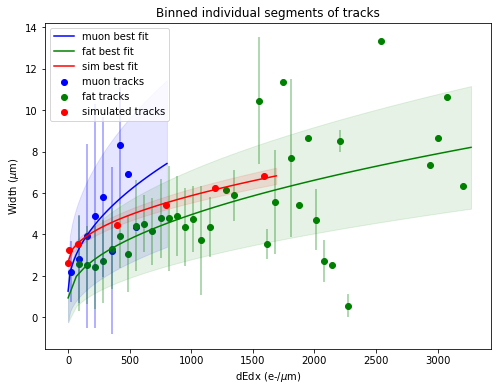

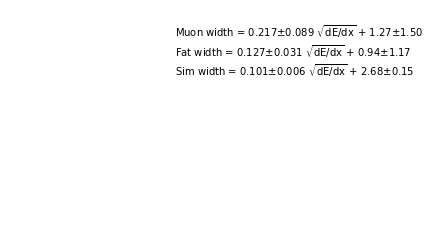

In [34]:
bins = np.linspace(min(dedxs), max(dedxs_fat), 50)
binMids = bins[1:]-(bins[1]-bins[0])

dig = np.digitize(dedxs, bins)
binMeans = np.array([np.mean(widths[dig==i]) for i in range(1,len(bins))])
binStdvs = np.array([np.std(widths[dig==i]) for i in range(1,len(bins))])
nans = np.isnan(binMeans)

fn = sqrtfn2

res, cov = curve_fit(fn, binMids[~nans], binMeans[~nans])
cov = np.sqrt(np.diag(cov))

dig_fat = np.digitize(dedxs_fat, bins)
binMeans_fat = np.array([np.mean(widths_fat[dig_fat==i]) for i in range(1,len(bins))])
binStdvs_fat = np.array([np.std(widths_fat[dig_fat==i]) for i in range(1,len(bins))])
nans_fat = np.isnan(binMeans_fat)

res_fat, cov_fat = curve_fit(fn, binMids[~nans_fat], binMeans_fat[~nans_fat])
cov_fat = np.sqrt(np.diag(cov_fat))

res_sim, cov_sim = curve_fit(fn, dedxs_sim, widths_sim)
cov_sim = np.sqrt(np.diag(cov_sim))


plt.figure(figsize=(8,6))
plt.errorbar(binMids, binMeans, binStdvs, color='b', alpha=0.4, fmt='none')
plt.scatter(binMids, binMeans, c='b', label='muon tracks')
plt.errorbar(binMids, binMeans_fat, binStdvs_fat, color='g', alpha=0.4, fmt='none')
plt.scatter(binMids, binMeans_fat, c='g', label='fat tracks')

dom = np.linspace(0,max(dedxs)+200)
plt.plot(dom, fn(dom, *res), c='b', label='muon best fit')#slope = %.2e +/- %.2e'%(m,cov[0]))
plt.fill_between(dom, fn(dom, *(res-cov)), fn(dom, *(res+cov)), color='b', alpha=0.1)

dom_fat = np.linspace(0,max(dedxs_fat))
plt.plot(dom_fat, fn(dom_fat, *res_fat), c='g', label='fat best fit')#slope = %.2e +/- %.2e'%(m_fat,cov_fat[0]))
plt.fill_between(dom_fat, fn(dom_fat, *(res_fat-cov_fat)), fn(dom_fat, *(res_fat+cov_fat)), color='g', alpha=0.1)


plt.scatter(dedxs_sim, widths_sim, color='r', label='simulated tracks', zorder=5)
dom_sim = np.array([0,max(dedxs_sim)+100])
dom_sim = np.linspace(0,max(dedxs_sim)+100)
plt.plot(dom_sim, fn(dom_sim, *res_sim), c='r', label='sim best fit')#slope = %.2e +/- %.2e'%(m_sim,cov_sim[0]))
plt.fill_between(dom_sim, fn(dom_sim, *(res_sim-cov_sim)), fn(dom_sim, *(res_sim+cov_sim)), color='r', alpha=0.1)


plt.title('Binned individual segments of tracks')
plt.xlabel(r'dEdx (e-/$\mu$m)')
plt.ylabel(r'Width ($\mu$m)')
plt.legend()

plt.figure()
plt.plot()
plt.text(0.5,0.9, r'Muon width = %.3f$\pm$%.3f $\sqrt{\rm{dE/dx}}$ + %.2f$\pm$%.2f'%(res[0],cov[0],
                                                                                     res[1],cov[1]))
plt.text(0.5,0.8, r'Fat width = %.3f$\pm$%.3f $\sqrt{\rm{dE/dx}}$ + %.2f$\pm$%.2f'%(res_fat[0],cov_fat[0],
                                                                                    res_fat[1],cov_fat[1]))
plt.text(0.5,0.7, r'Sim width = %.3f$\pm$%.3f $\sqrt{\rm{dE/dx}}$ + %.2f$\pm$%.2f'%(res_sim[0],cov_sim[0],
                                                                                    res_sim[1],cov_sim[1]))
plt.axis('off')

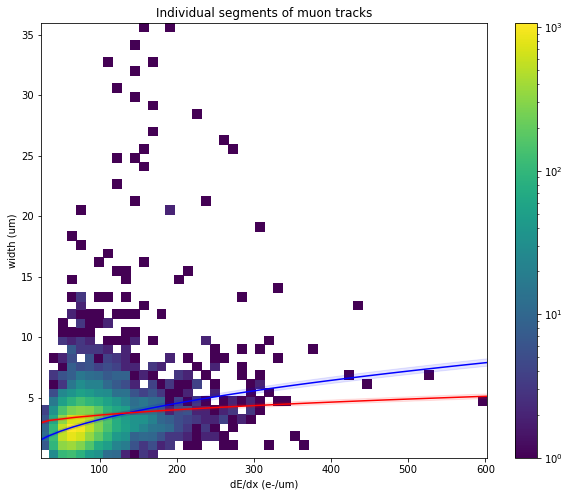

In [167]:
plt.figure(figsize=(10,8))
plt.hist2d(dedxs, widths, bins=50, norm=mpl.colors.LogNorm())
plt.colorbar()

plt.plot(dom, fn(dom, *res), c='b', label='muon best fit')#slope = %.2e +/- %.2e'%(m,cov[0]))
plt.fill_between(dom, fn(dom, *(res-cov)), fn(dom, *(res+cov)), color='b', alpha=0.1)

plt.plot(dom_sim, fn(dom_sim, *res_sim), c='r', label='sim best fit')#slope = %.2e +/- %.2e'%(m_sim,cov_sim[0]))
plt.fill_between(dom_sim, fn(dom_sim, *(res_sim-cov_sim)), fn(dom_sim, *(res_sim+cov_sim)), color='r', alpha=0.1)

plt.title('Individual segments of muon tracks')
plt.xlabel('dE/dx (e-/um)')
plt.ylabel('width (um)')
plt.show()

In [164]:
def getR2(obspts, modelpts):
    rss = sum((obspts-modelpts)**2)
    tss = sum((obspts-np.mean(obspts))**2)
    return 1 - rss/tss

fn = linear

res, _ = curve_fit(fn, dedxs, widths)
res_fat, _ = curve_fit(fn, dedxs_fat, widths_fat)

print('Unbinned muon linear fit R^2:', getR2(widths, fn(dedxs, *res)))
print('Unbinned fat linear fit R^2:', getR2(widths_fat, fn(dedxs_fat, *res_fat)))

res, _ = curve_fit(fn, binMids[~nans], binMeans[~nans])
res_fat, _ = curve_fit(fn, binMids[~nans_fat], binMeans_fat[~nans_fat])

print('Binned muon linear fit R^2:', getR2(binMeans[~nans], fn(binMids[~nans], *res)))
print('Binned fat linear fit R^2:', getR2(binMeans_fat[~nans_fat], fn(binMids[~nans_fat], *res_fat)))


fn = sqrtfn2

res, _ = curve_fit(fn, dedxs, widths)
res_fat, _ = curve_fit(fn, dedxs_fat, widths_fat)

print('\nUnbinned muon square root fit R^2:', getR2(widths, fn(dedxs, *res)))
print('Unbinned fat square root fit R^2:', getR2(widths_fat, fn(dedxs_fat, *res_fat)))

res, _ = curve_fit(fn, binMids[~nans], binMeans[~nans])
res_fat, _ = curve_fit(fn, binMids[~nans_fat], binMeans_fat[~nans_fat])

print('Binned muon square root fit R^2:', getR2(binMeans[~nans], fn(binMids[~nans], *res)))
print('Binned fat square root fit R^2:', getR2(binMeans_fat[~nans_fat], fn(binMids[~nans_fat], *res_fat)))

res_sim, _ = curve_fit(linear, dedxs_sim, widths_sim)
print('\nSimulated linear fit R^2:', getR2(widths_sim, linear(dedxs_sim, *res_sim)))
res_sim, _ = curve_fit(sqrtfn2, dedxs_sim, widths_sim)
print('Simulated square root fit R^2:', getR2(widths_sim, sqrtfn2(dedxs_sim, *res_sim)))

Unbinned muon linear fit R^2: 0.08119605254718543
Unbinned fat linear fit R^2: 0.19649936109380406
Binned muon linear fit R^2: 0.3975141385758769
Binned fat linear fit R^2: 0.2531617187160785

Unbinned muon square root fit R^2: 0.08018737528503628
Unbinned fat square root fit R^2: 0.1912404692037848
Binned muon square root fit R^2: 0.4861126122388144
Binned fat square root fit R^2: 0.25697375271830325

Simulated linear fit R^2: 0.9539758710975681
Simulated square root fit R^2: 0.9950585974733605


<h5>See other notebook for finalized plots</h5>

In [28]:
data = [dedxs_fat, depths_fat, widths_fat,
        dedxs_sim40, [40]*len(files40), widths_sim40,
        dedxs_sim, [90]*len(files), widths_sim]

with open('dedx-depth-width_plotdata_no-corrs.obj', 'wb') as f:
    pickle.dump(data, f)

In [19]:
len(widthErrs_fat)

528

In [20]:
with open('widtherrs.obj', 'wb') as f:
    pickle.dump(widthErrs_fat, f)

<IPython.core.display.Javascript object>


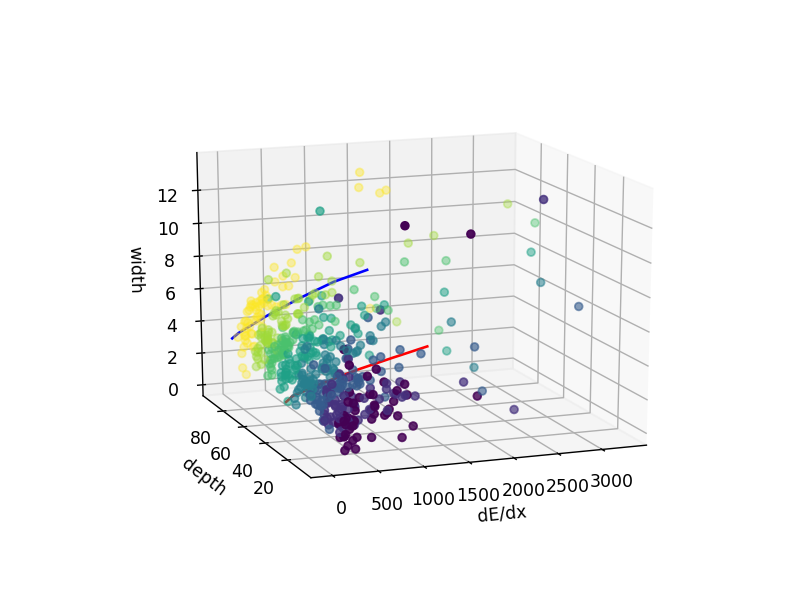

In [57]:
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

inds = depths_fat>0
opp = []
for o in opposing:
    if o:
        opp.append('C1')
    else:
        opp.append('C0')

s = ax.scatter(dedxs_fat[inds], depths_fat[inds], widths_fat[inds], c=depths_fat[inds])
ax.plot(dedxs_sim40, [40]*len(files40), widths_sim40, c='r')
ax.plot(dedxs_sim, [90]*len(files), widths_sim, c='b')
ax.set_xlabel('dE/dx')
ax.set_ylabel('depth')
ax.set_zlabel('width')
ax.view_init(30, -120)
ax.autoscale(tight=True)

In [28]:
%matplotlib inline

<IPython.core.display.Javascript object>


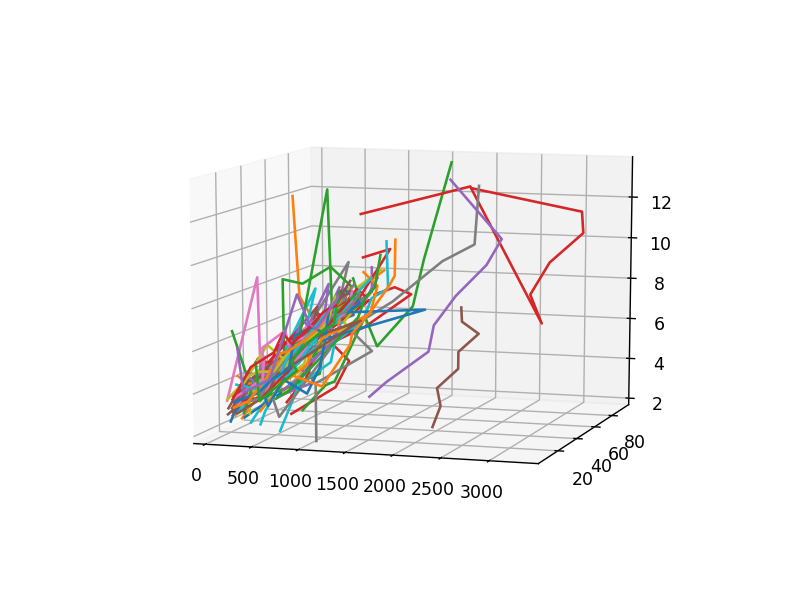

In [28]:
fig = plt.figure()
ax1 = fig.add_subplot(projection='3d')

for t in fats:
    if t.PSFUseable:
        _,sig,_ = np.array(t.segGaussian).T * t.pitch
        dep = t.segDepths
        dedx = t.segDedx
        
        ax1.plot(dedx,dep,sig)

<h2>Look at energy distributions</h2>

Text(0.5, 0, 'dE/dx (e-/um)')

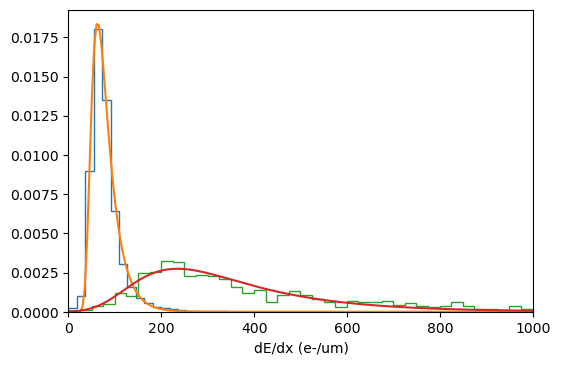

In [82]:
def landau(DeltaE, MPV, xi):
    lamb = (DeltaE-MPV)/xi
    return 1/np.sqrt(2*np.pi)/xi * np.exp(-0.5*(lamb + np.exp(-lamb)))

plt.figure(dpi=100)

dedxs_all = np.array([t.segDedx for t in linears]).flatten()
dedxs_fat = np.array([t.segDedx for t in fats]).flatten()
dedxs_muon = np.array([t.segDedx for t in linears if not t.isFat]).flatten()

vals, bins, _ = plt.hist(dedxs_muon, bins=40, density=True, histtype='step')
# vals,bins,_ = plt.hist(dedxs_all[dedxs_all<1000], bins=bins, density=True, histtype='step')
# vals,bins,_ = plt.hist(dedxs_fat[dedxs_fat<1000], bins=40, density=True, histtype='step')
# plt.yscale('log')

bin_mids = bins[:-1] + np.diff(bins)/2
res, cov = curve_fit(landau, bin_mids, vals, p0=(200,150))
x = np.linspace(0,1000,200)

plt.plot(x, landau(x,*res))
plt.xlim(0,1000)

vals,bins,_ = plt.hist(dedxs_fat[dedxs_fat<1000], bins=40, density=True, histtype='step')
bin_mids = bins[:-1] + np.diff(bins)/2
res, cov = curve_fit(landau, bin_mids, vals, p0=(200,150))
plt.plot(x, landau(x,*res))

plt.xlabel('dE/dx (e-/um)')

In [176]:
print(res, np.sqrt(np.diag(cov)))

[71.42634308  7.35449086] [0.20766764 0.12357633]


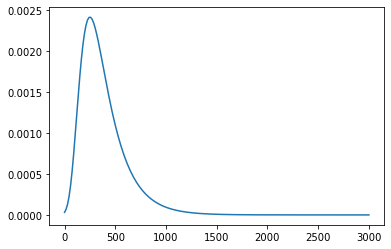

In [131]:
x = np.linspace(0,3000,200)
plt.plot(x, landau(x,250,100))

In [165]:
np.mean([t.beta for t in linears if t.isFat])

0.4623940914857604

<h2>Compare tracks at different altitudes</h2>

In [6]:
with open('LSSTCam_brightest4.obj', 'rb') as file:
    LSSTCam4 = pickle.load(file)
with open('ComCam_brightest4.obj', 'rb') as file:
    ComCam4 = pickle.load(file)
with open('PFS_brightest4.obj', 'rb') as file:
    PFS4 = pickle.load(file)

Text(0.8, 0.91, 'LSSTCam, SLAC\nAltitude = 0.1 km')

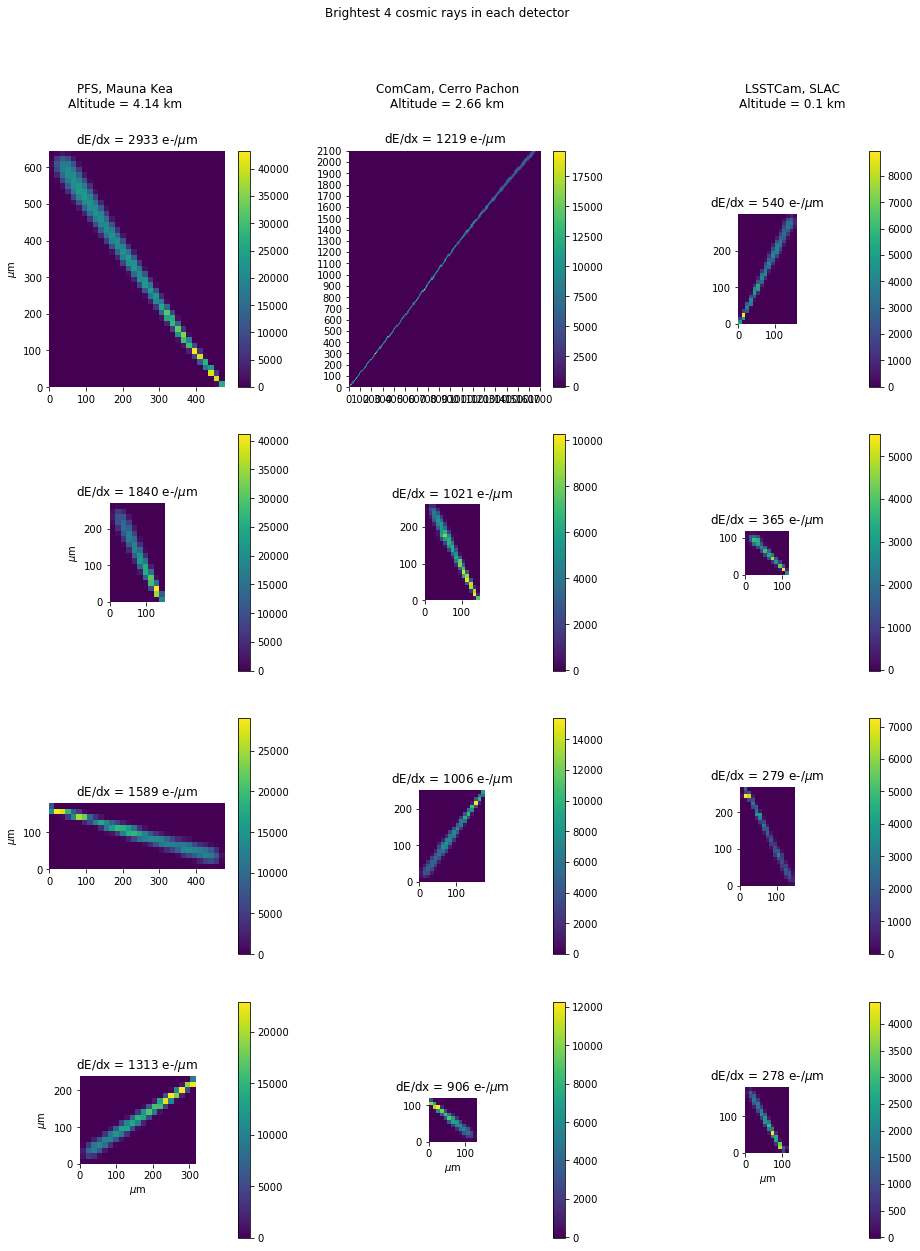

In [19]:
def formatImage(ax, arr, sh, pixelSize, matchAx, matchSh):
    '''matchSh should be the shape in microns'''
    im = ax.imshow(arr, extent=pixelSize*np.array([0,sh[1],0,sh[0]]), origin='lower')
    plt.colorbar(im, ax=ax)
    
    #center image in Axes
    xdiff = (matchSh[1] - pixelSize*sh[1])/2
    ydiff = (matchSh[0] - pixelSize*sh[0])/2
    ax.set_xlim((lim - xdiff for lim in matchAx.get_xlim()))
    ax.set_ylim((lim - ydiff for lim in matchAx.get_ylim()))
    
    #axis visibilities
    ax.spines['left'].set_position('zero')
    ax.spines['bottom'].set_position('zero')
    ax.set_frame_on(False)
    ax.set_xticks(np.arange(0,pixelSize*sh[1],100))
    ax.set_yticks(np.arange(0,pixelSize*sh[0],100))

sh0 = PFS4[0].imArray.shape
sh0um = 15*np.array(sh0)
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(16,20))
for i in range(4):
    ax = axs[i][0]
    arr = PFS4[i].imArray
    sh = arr.shape
    im = ax.imshow(arr, extent=15*np.array([0,sh[1],0,sh[0]]), origin='lower')
    fig.colorbar(im, ax=ax)
    xdiff = 15*(sh0[1]-sh[1])/2
    ydiff = 15*(sh0[0]-sh[0])/2
    ax.set_xlim((lim - xdiff for lim in axs[0,0].get_xlim()))
    ax.set_ylim((lim - ydiff for lim in axs[0,0].get_ylim()))
    ax.spines['left'].set(position='zero')
    ax.set_yticks(np.arange(0,15*sh[0],100))
    ax.spines['bottom'].set(position='zero')
    ax.set_xticks(np.arange(0,15*sh[1],100))
    ax.set_frame_on(False)
    ax.text(15*sh[1]/2, 15*sh[0]+30, r'dE/dx = %.0f e-/$\mu$m'%PFS4[i].dedx, ha='center', va='center', size='large')
    ax.set_ylabel(r'$\mu$m')
    if i==3: ax.set_xlabel(r'$\mu$m')
    
    ax = axs[i][1]
    arr = ComCam4[i].imArray
    sh = arr.shape
    im = ax.imshow(arr, extent=10*np.array([0,sh[1],0,sh[0]]), origin='lower')
#     ax.set_title(r'dE/dx = %.0f e-/$\mu$m'%ComCam4[i].dedx)
    fig.colorbar(im, ax=ax)
    xdiff = 10*(1.5*sh0[1]-sh[1])/2
    ydiff = 10*(1.5*sh0[0]-sh[0])/2
    ax.set_xlim((lim - xdiff for lim in axs[0,0].get_xlim()))
    ax.set_ylim((lim - ydiff for lim in axs[0,0].get_ylim()))
    ax.spines['left'].set(position='zero')
    ax.set_yticks(np.arange(0,10*sh[0],100))
    ax.spines['bottom'].set(position='zero')
    ax.set_xticks(np.arange(0,10*sh[1],100))
    ax.set_frame_on(False)
    ax.text(10*sh[1]/2, 10*sh[0]+30, r'dE/dx = %.0f e-/$\mu$m'%ComCam4[i].dedx, ha='center', va='center', size='large')
    if i==3: ax.set_xlabel(r'$\mu$m')
    
    ax = axs[i][2]
    arr = LSSTCam4[i].imArray
    sh = arr.shape
    if sh[0]<sh[1]: arr = arr.T; sh = arr.shape
    formatImage(ax, arr, sh, 10, axs[0,0], sh0um)
    ax.text(10*sh[1]/2, 10*sh[0]+30, r'dE/dx = %.0f e-/$\mu$m'%LSSTCam4[i].dedx, ha='center', va='center', size='large')
    if i==3: ax.set_xlabel(r'$\mu$m')
    
plt.suptitle('Brightest 4 cosmic rays in each detector')
fig.text(0.22, 0.91, 'PFS, Mauna Kea\nAltitude = 4.14 km', fontsize='large', ha='center')
fig.text(0.5, 0.91, 'ComCam, Cerro Pachon\nAltitude = 2.66 km', fontsize='large', ha='center')
fig.text(0.8, 0.91, 'LSSTCam, SLAC\nAltitude = 0.1 km', fontsize='large', ha='center')

Text(0.8, 0.91, 'LSSTCam, SLAC\nAltitude = 0.1 km')

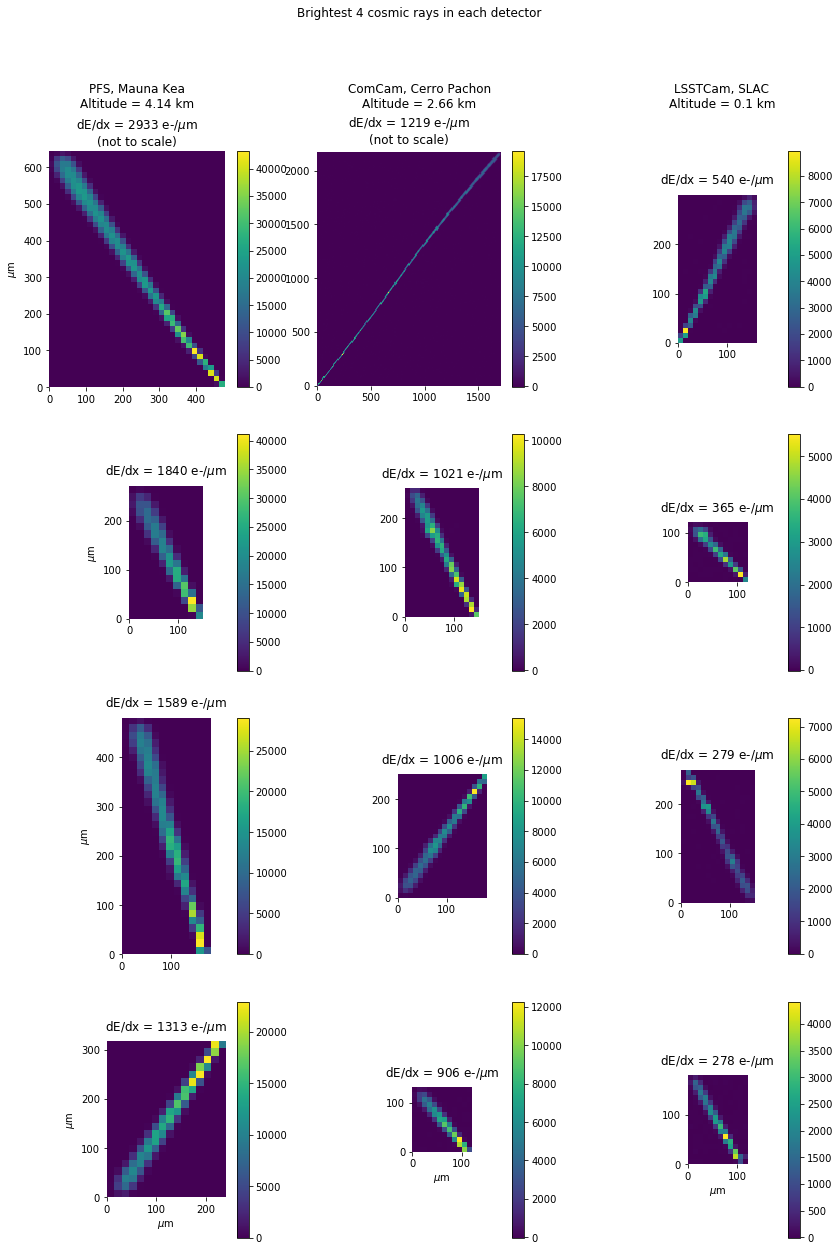

In [54]:
def formatImage2(ax, arr, sh, pixelSize, axlims):
    '''matchSh should be the shape in microns'''
    im = ax.imshow(arr, extent=pixelSize*np.array([0,sh[1],0,sh[0]]), origin='lower')
    plt.colorbar(im, ax=ax)
    
    #center image in Axes
    xdiff = (axlims[1] - pixelSize*sh[1])/2
    ydiff = (axlims[0] - pixelSize*sh[0])/2
    ax.set_xlim((0-xdiff, axlims[1]-xdiff))
    ax.set_ylim((0-ydiff, axlims[0]-ydiff))
    
    #axis visibilities
    ax.spines['left'].set_position('zero')
    ax.spines['bottom'].set_position('zero')
    ax.set_frame_on(False)
    ax.set_xticks(np.arange(0,pixelSize*sh[1],100))
    ax.set_yticks(np.arange(0,pixelSize*sh[0],100))
    
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(14,20))
axlims = (480,240)

ax = axs[0,0]
arr = PFS4[0].imArray
sh = arr.shape
formatImage2(ax, arr, sh, 15, 15*np.array(sh))
ax.text(15*sh[1]/2, 15*sh[0]+50, r'dE/dx = %.0f e-/$\mu$m'%PFS4[0].dedx+'\n(not to scale)',
        ha='center', va='center', size='large')
ax.set_ylabel(r'$\mu$m')

ax = axs[0,1]
arr = ComCam4[0].imArray
sh = arr.shape
formatImage2(ax, arr, sh, 10, 10*np.array(sh))
ax.text(10*sh[1]/2, 10*sh[0]+200, r'dE/dx = %.0f e-/$\mu$m'%ComCam4[0].dedx+'\n(not to scale)',
        ha='center', va='center', size='large')
ax.set_xticks(np.arange(0,10*sh[1],500))
ax.set_yticks(np.arange(0,10*sh[0],500))

ax = axs[0,2]
arr = LSSTCam4[0].imArray
sh = arr.shape
formatImage2(ax, arr, sh, 10, axlims)
ax.text(10*sh[1]/2, 10*sh[0]+30, r'dE/dx = %.0f e-/$\mu$m'%LSSTCam4[0].dedx, ha='center', va='center', size='large')

for i in range(1,4):
    ax = axs[i][0]
    arr = PFS4[i].imArray
    sh = arr.shape
    if sh[0]<sh[1]: arr = arr.T; sh = arr.shape
    formatImage2(ax, arr, sh, 15, axlims)
    ax.text(15*sh[1]/2, 15*sh[0]+30, r'dE/dx = %.0f e-/$\mu$m'%PFS4[i].dedx, ha='center', va='center', size='large')
    ax.set_ylabel(r'$\mu$m')
    if i==3: ax.set_xlabel(r'$\mu$m')
    
    ax = axs[i][1]
    arr = ComCam4[i].imArray
    sh = arr.shape
    if sh[0]<sh[1]: arr = arr.T; sh = arr.shape
    formatImage2(ax, arr, sh, 10, axlims)
    ax.text(10*sh[1]/2, 10*sh[0]+30, r'dE/dx = %.0f e-/$\mu$m'%ComCam4[i].dedx, ha='center', va='center', size='large')
    if i==3: ax.set_xlabel(r'$\mu$m')
    
    ax = axs[i][2]
    arr = LSSTCam4[i].imArray
    sh = arr.shape
    if sh[0]<sh[1]: arr = arr.T; sh = arr.shape
    formatImage2(ax, arr, sh, 10, axlims)
    ax.text(10*sh[1]/2, 10*sh[0]+30, r'dE/dx = %.0f e-/$\mu$m'%LSSTCam4[i].dedx, ha='center', va='center', size='large')
    if i==3: ax.set_xlabel(r'$\mu$m')
        
plt.suptitle('Brightest 4 cosmic rays in each detector')
fig.text(0.22, 0.91, 'PFS, Mauna Kea\nAltitude = 4.14 km', fontsize='large', ha='center')
fig.text(0.5, 0.91, 'ComCam, Cerro Pachon\nAltitude = 2.66 km', fontsize='large', ha='center')
fig.text(0.8, 0.91, 'LSSTCam, SLAC\nAltitude = 0.1 km', fontsize='large', ha='center')